In [1]:
import pandas as pd
import numpy as np
import glob

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from bids.layout import BIDSLayout, parse_file_entities

from nilearn.plotting import plot_event

In [ ]:
#root = '/nese/mit/group/sig/om_projects/voice/bids/data/sub-voice*'

# counts = {}

# for r in glob.glob(root):
#     path = r + '/ses-1/func/*events.tsv'
#     pop_events = pd.DataFrame(glob.glob(path), columns= ['events_file'])
    
#     {r.split('sub-voice')[1]:{f.split('task-')[1]:not pd.read_table(f).empty for f in pop_events.events_file}}

In [3]:
#def find_populated_events(events_path_pattern):
def find_populated_events(events_path_list):

    #get list of all events file in bids directory (using old location) per task as df
    #pop_events = pd.DataFrame(glob.glob(f'/om/project/voice/bids/data/sub-voice*/ses-*/func/*{task}*events.tsv'), columns= ['events_file'])

    #pop_events = pd.DataFrame(glob.glob(events_path_pattern), columns= ['events_file'])
    pop_events = pd.DataFrame(events_path_list, columns= ['events_file'])

    #use pd empty attribute to determine if file is empty or not. 
    #invert the boolean value as I want to know if it is popualated or not
    pop_events['populated'] = [not pd.read_table(f).empty for f in pop_events.events_file]

    pop_events['task'] = [parse_file_entities(file)['task'] for file in pop_events.events_file]

    return pop_events



In [17]:
path = '/nese/mit/group/sig/om_projects/voice/bids/data/sub-voice*/ses-*/func/*events.tsv'

ev_path_all = glob.glob(path)

control_sub = np.arange(986,1000).astype('str')
#control_sub = [str(c) for c in control_sub]

#crappy way to remove control subjects
events_path_list_filtered = []
for e in ev_path_all:
    if any(substring in e for substring in control_sub):
        continue
    else:
        events_path_list_filtered.append(e)
        
pop_events = find_populated_events(events_path_list_filtered)

#events_all = glob.glob(path)
runs = ['run-01', 'run-02'] #run names have 0 padding
events_by_taskrun = {t+'_'+ r:[e for e in events_path_list_filtered if t in e if r in e] for t in pop_events.task.unique() for r in runs}
[events_by_taskrun.pop(k) for k in 
 ['pitchnw_run-01', 'pitchnw_run-02','facematch_run-01', 'facematch_run-02', 'pitchsent_run-01', 'pitchsent_run-02']]
events_by_taskrun.keys()

dict_keys(['pataka_run-01', 'pataka_run-02', 'emosent_run-01', 'emosent_run-02', 'nwr_run-01', 'nwr_run-02', 'vowel_run-01', 'vowel_run-02'])

In [18]:
pop_events.groupby('task').populated.value_counts()

task       populated
emosent    True         118
           False         10
facematch  True          75
           False         35
nwr        True         167
           False          6
pataka     True          99
           False         22
pitchnw    True         115
           False          3
pitchsent  True         107
           False          9
vowel      True         120
           False          4
Name: count, dtype: int64

In [19]:
pop_events.populated.value_counts()

populated
True     801
False     89
Name: count, dtype: int64

In [153]:
#{grp: [data.onset.to_numpy() for grp, data in ev.groupby('trial_type') for ev in events]}

In [ ]:
# model_event = [a]
# event_labels = pd.concat(event['trial_type'] for event in model_event)
# event_labels = np.unique(event_labels)

# cmap_dictionary = {label:idx for idx, label in enumerate(event_labels)}

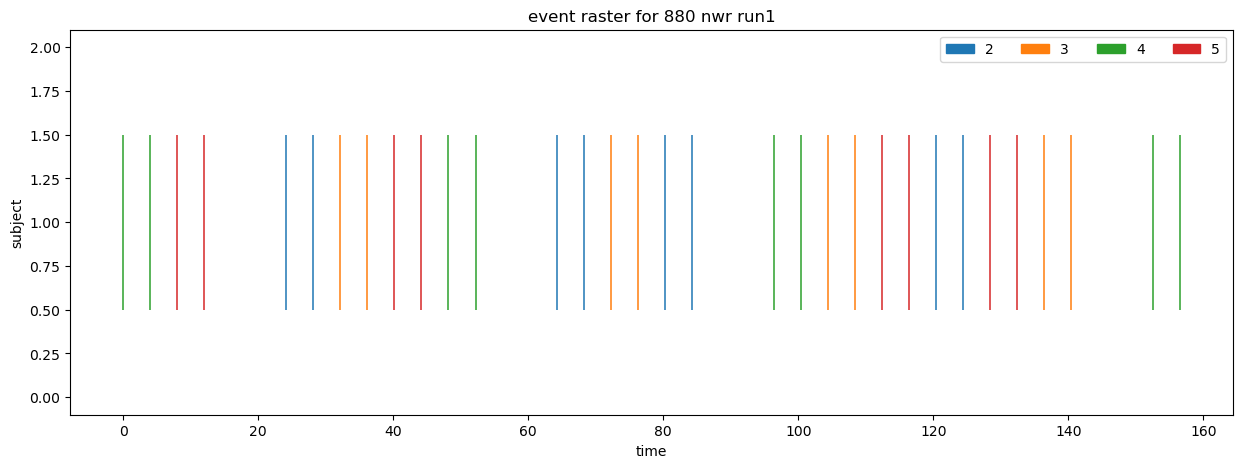

In [13]:
one_file='/nese/mit/group/sig/om_projects/voice/bids/data/sub-voice880/ses-1/func/sub-voice880_ses-1_task-nwr_run-01_events.tsv'

cmap = plt.cm.tab10
figure, ax = plt.subplots(figsize=(15,5))
one_event = pd.read_table(one_file)

event_labels = np.sort(one_event.trial_type.unique())
cmap_dictionary = {label:idx for idx, label in enumerate(event_labels)}

for grp, data in one_event.groupby('trial_type'):
    if grp == 'silent':
        continue
    elif grp == 'Rest':
        continue
    else:
        color = cmap.colors[cmap_dictionary[str(grp)]]
        ax.eventplot(data.onset.to_numpy(), linewidths=data.duration.iloc[0], colors=color)

if 'nwr' in one_file:
        cmap_dictionary.pop('Rest')

handles = []
for label, idx in cmap_dictionary.items():
    patch = mpatches.Patch(color=cmap.colors[idx], label=label)
    handles.append(patch)

_ = ax.legend(handles=handles, ncol=4)

plt.xlabel('time')
plt.ylabel('subject')

plt.title(f'event raster for 880 nwr run1')
plt.show()



In [16]:
one_event.head(10)

,onset,duration,trial_type,nonword
0,0.00,1.1,4,nuplarative
1,4.02,1.1,4,allotastry
2,8.03,1.1,5,ionificate
3,12.05,1.1,5,uninagable
4,16.07,1.1,Rest,NaN
5,20.08,1.1,Rest,NaN
6,24.10,1.1,2,kabant
7,28.11,1.1,2,nadle
8,32.12,1.1,3,esconter
9,36.14,1.1,3,thiprisant


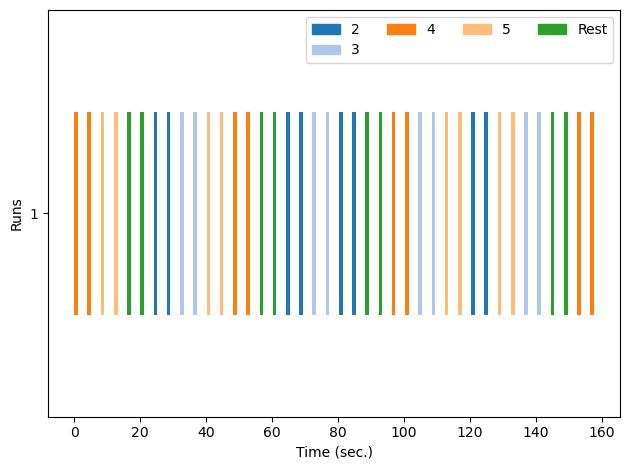

In [14]:
plot_event(one_event)
plt.show()

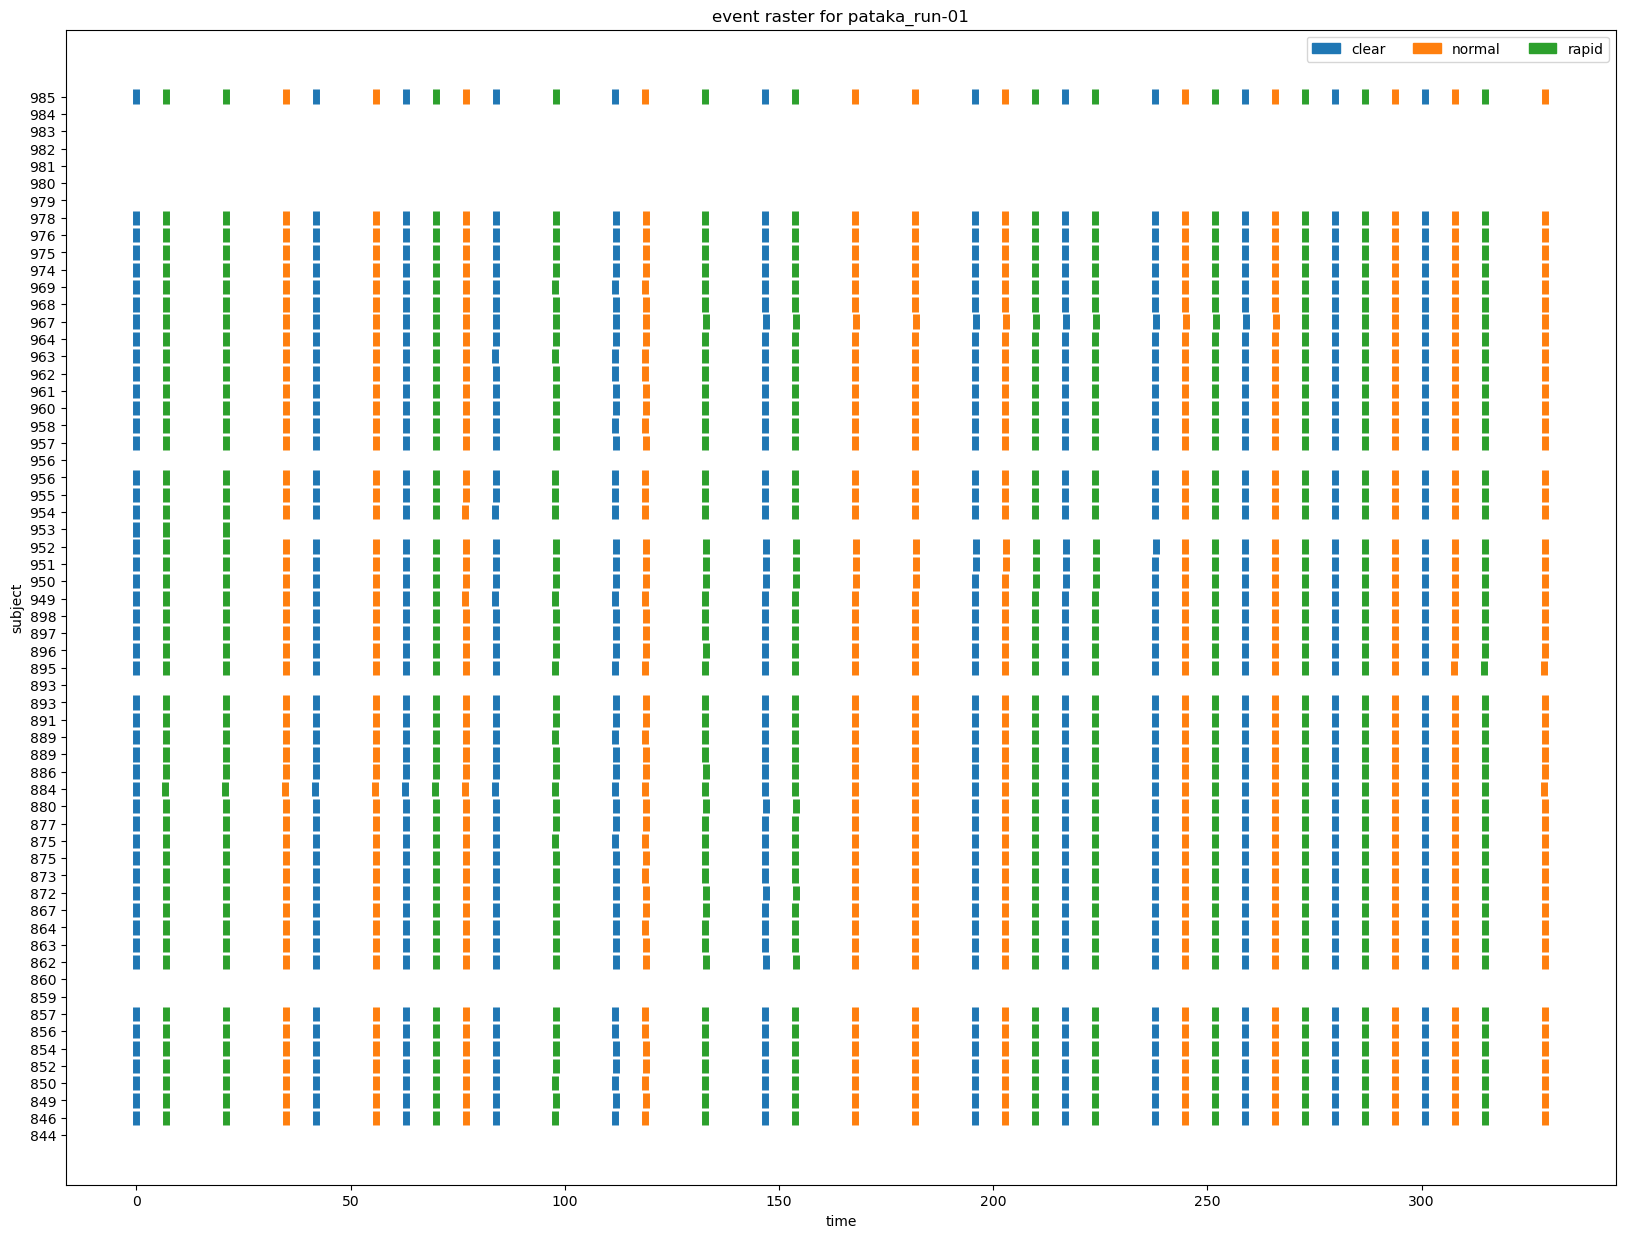

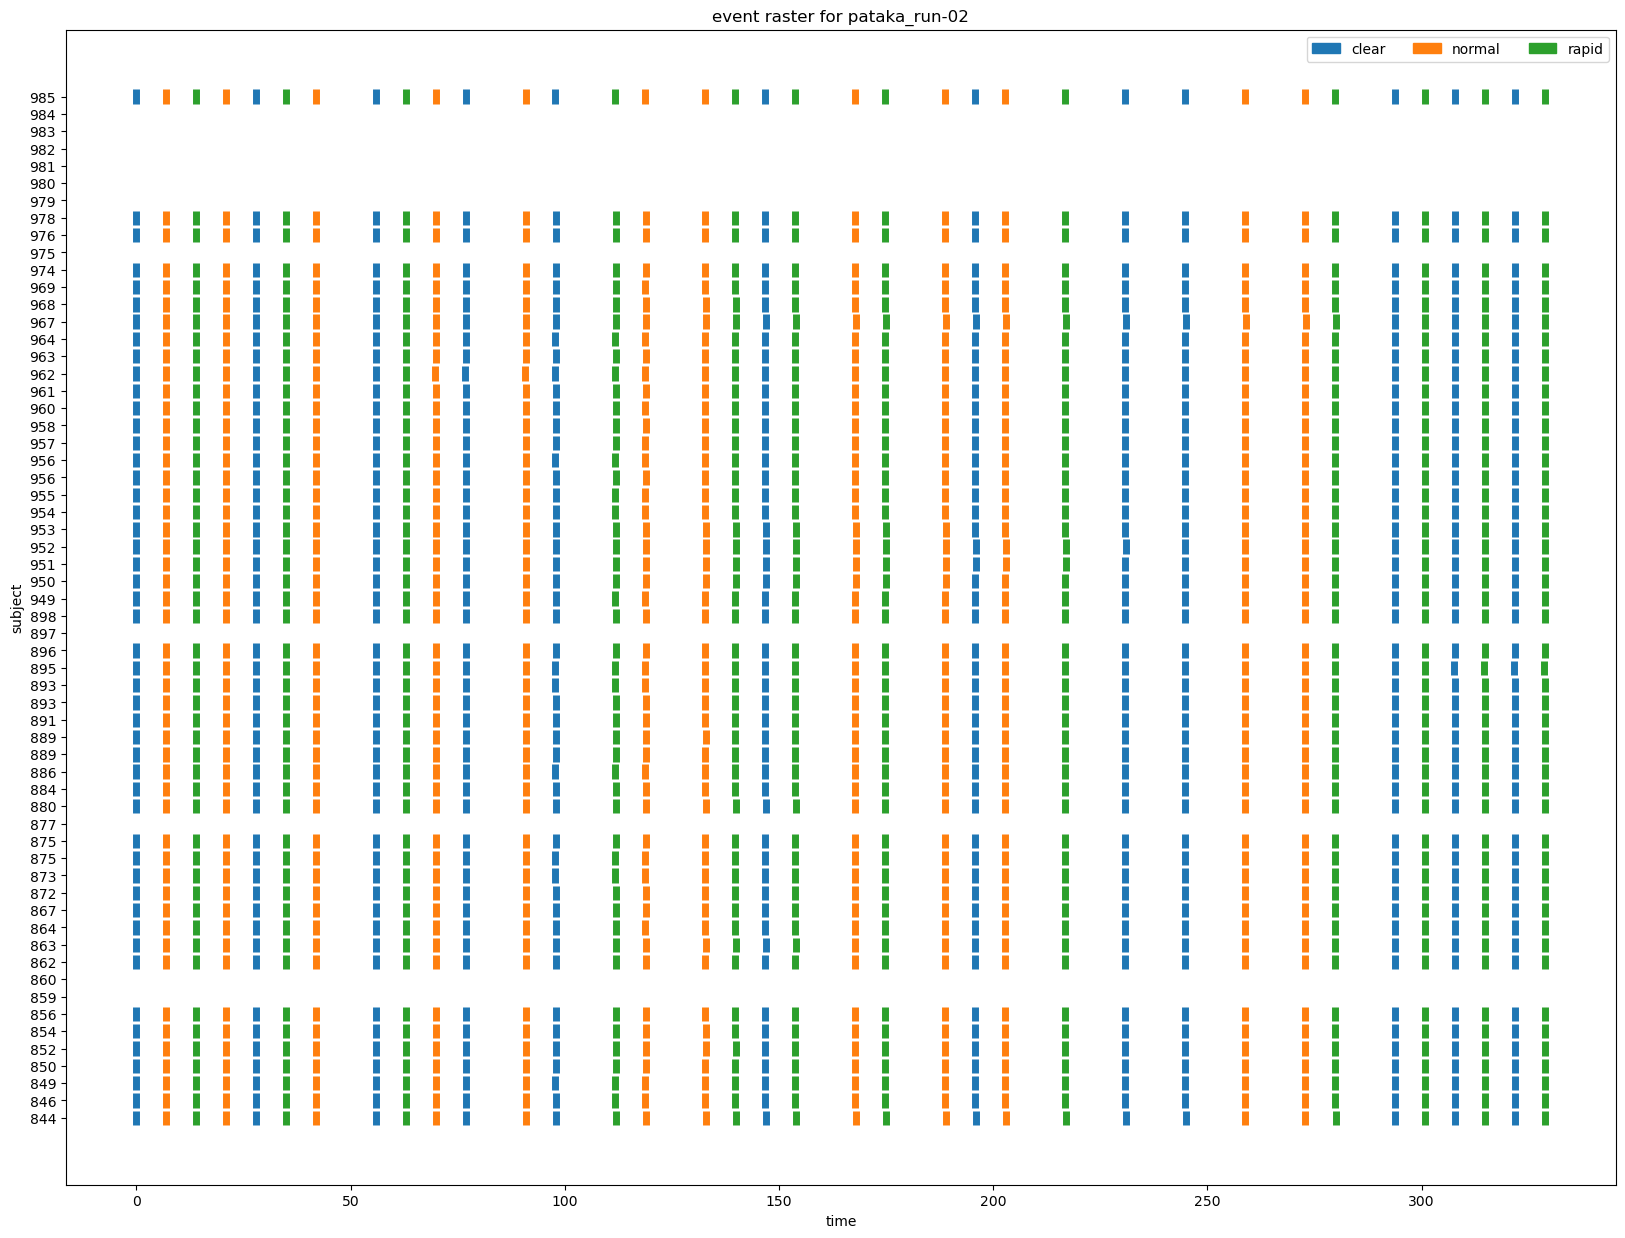

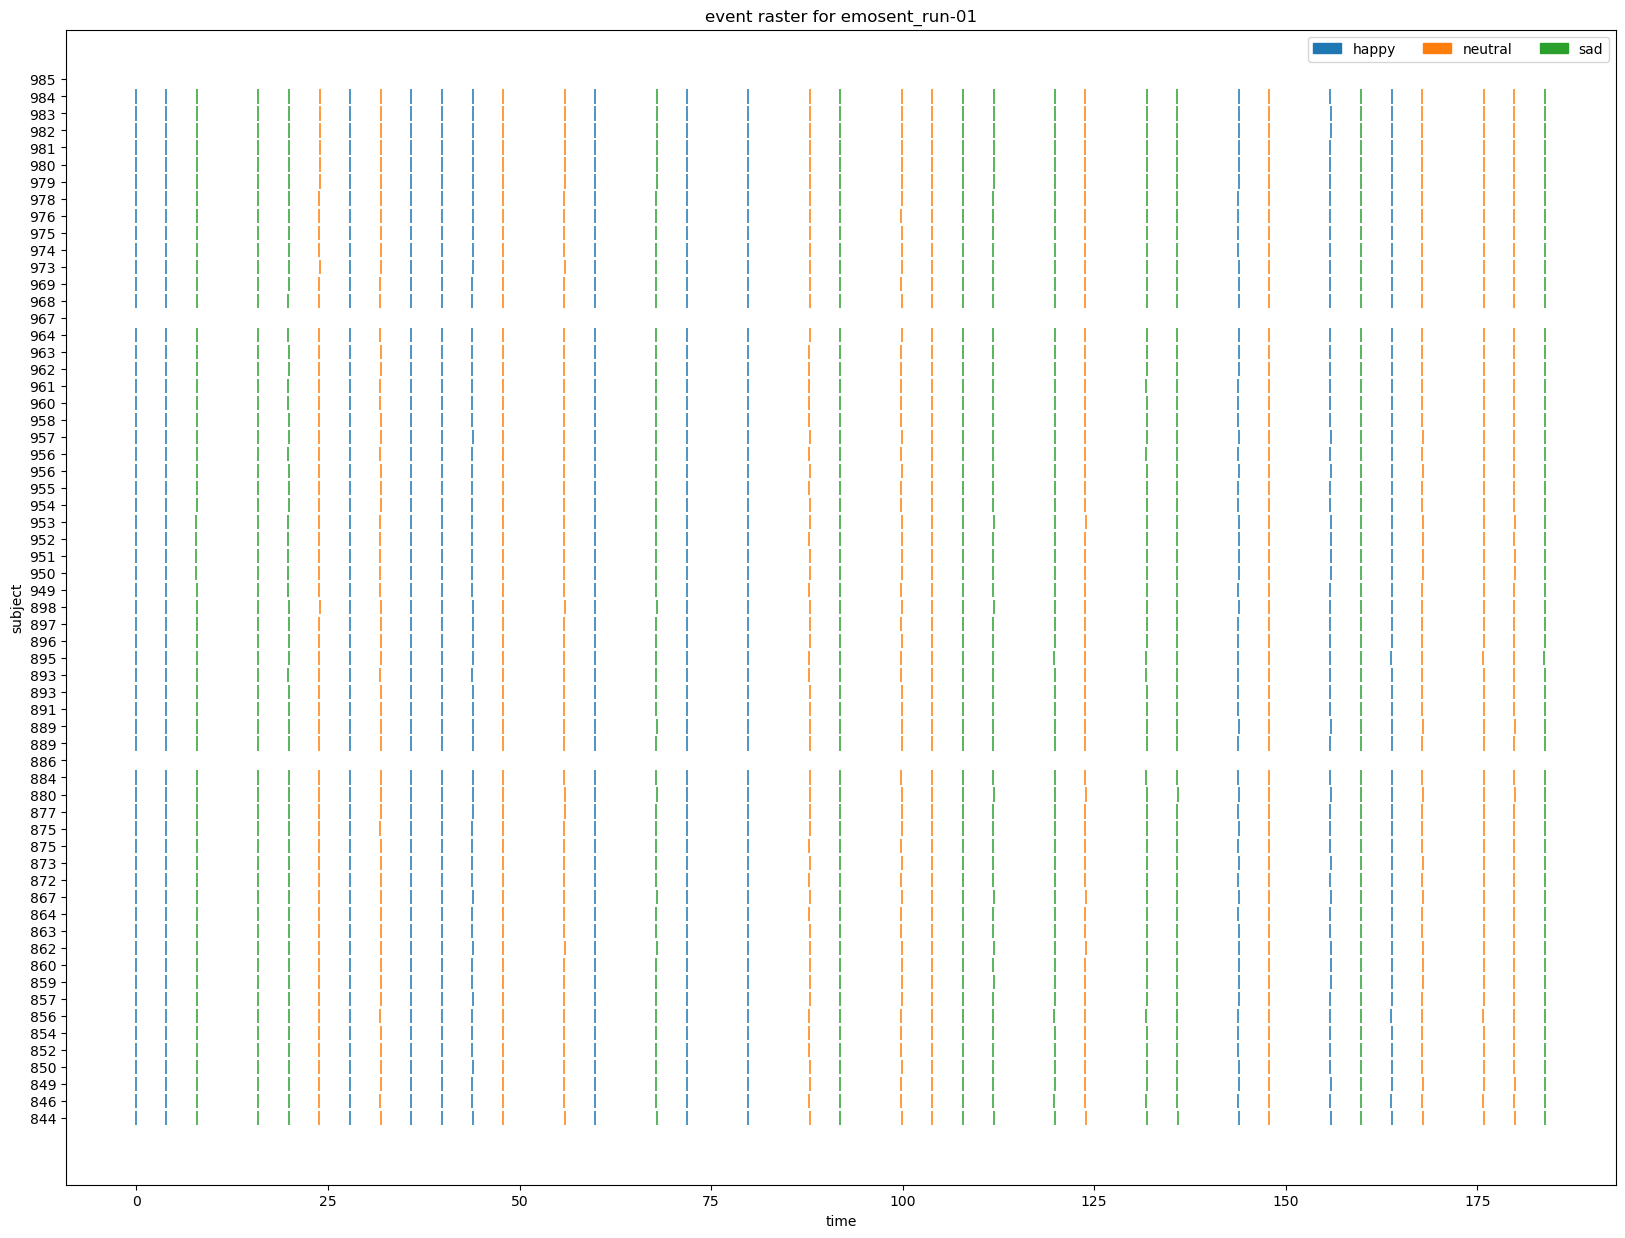

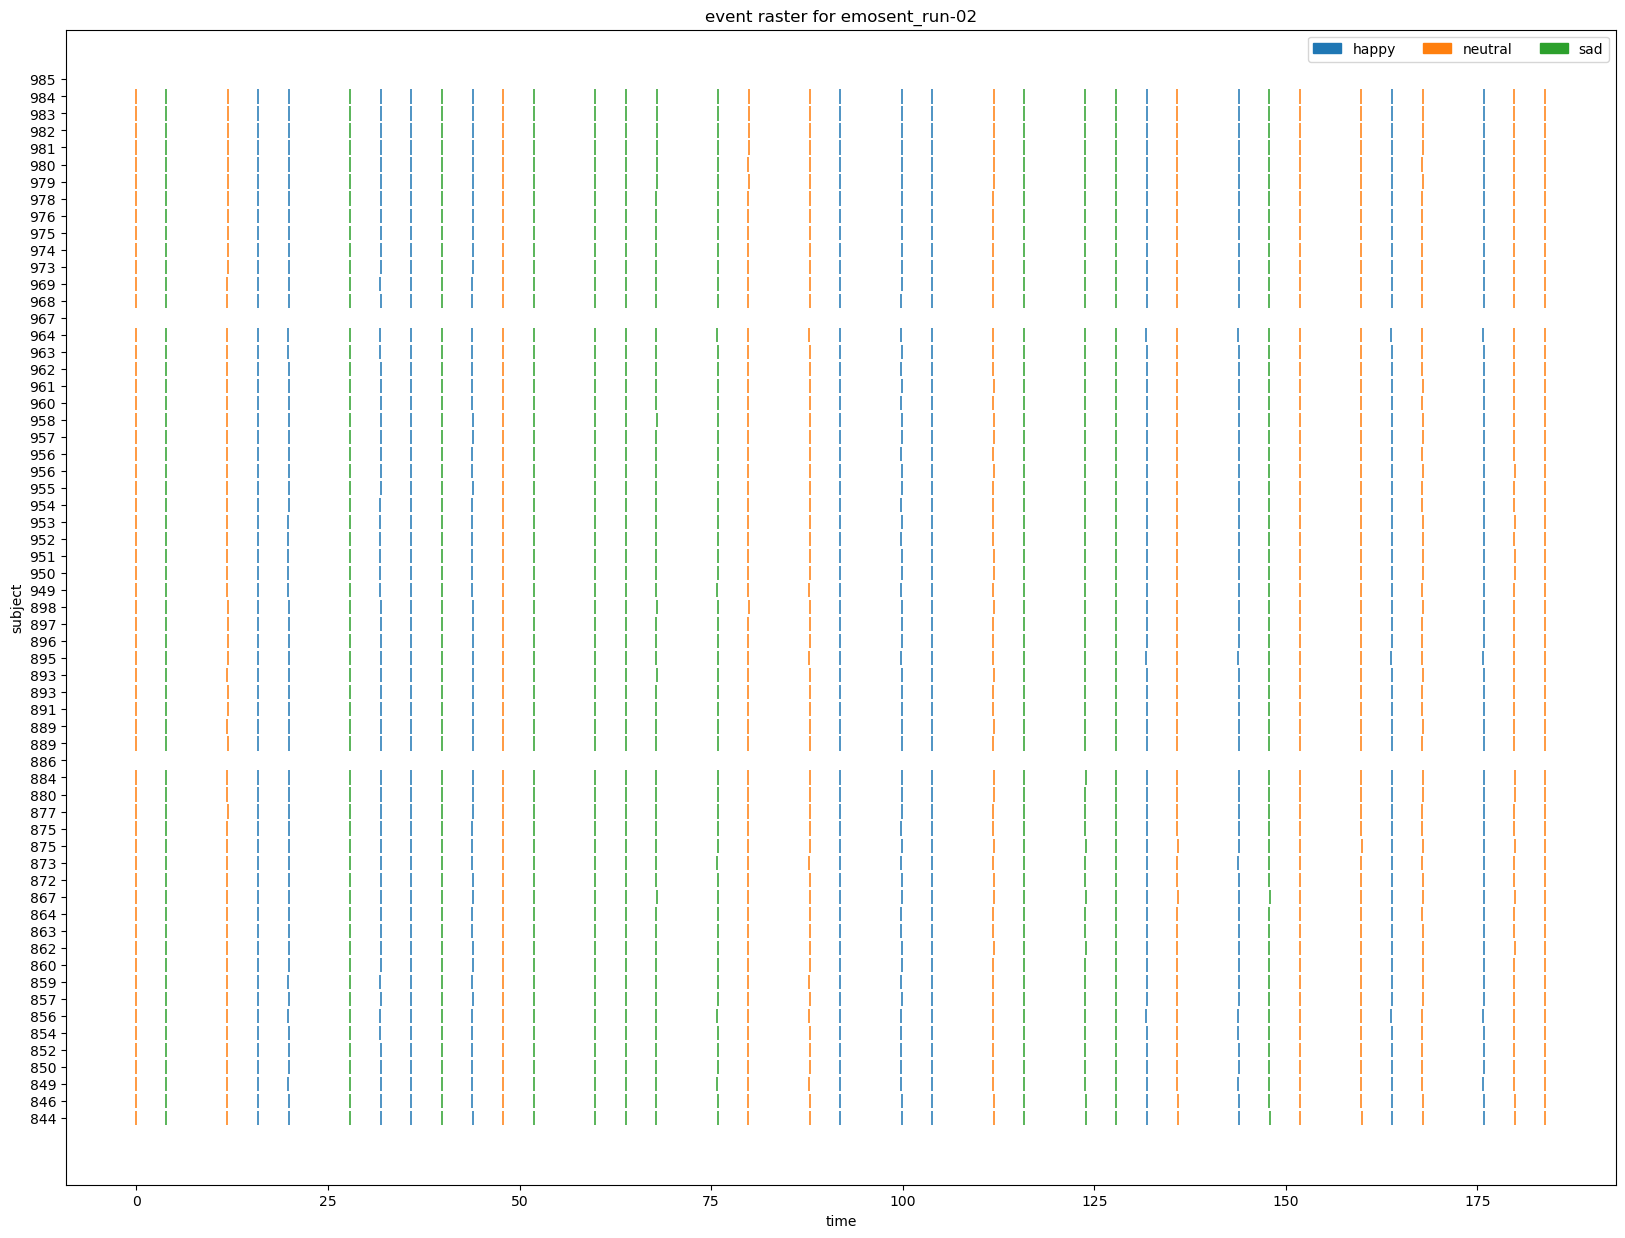

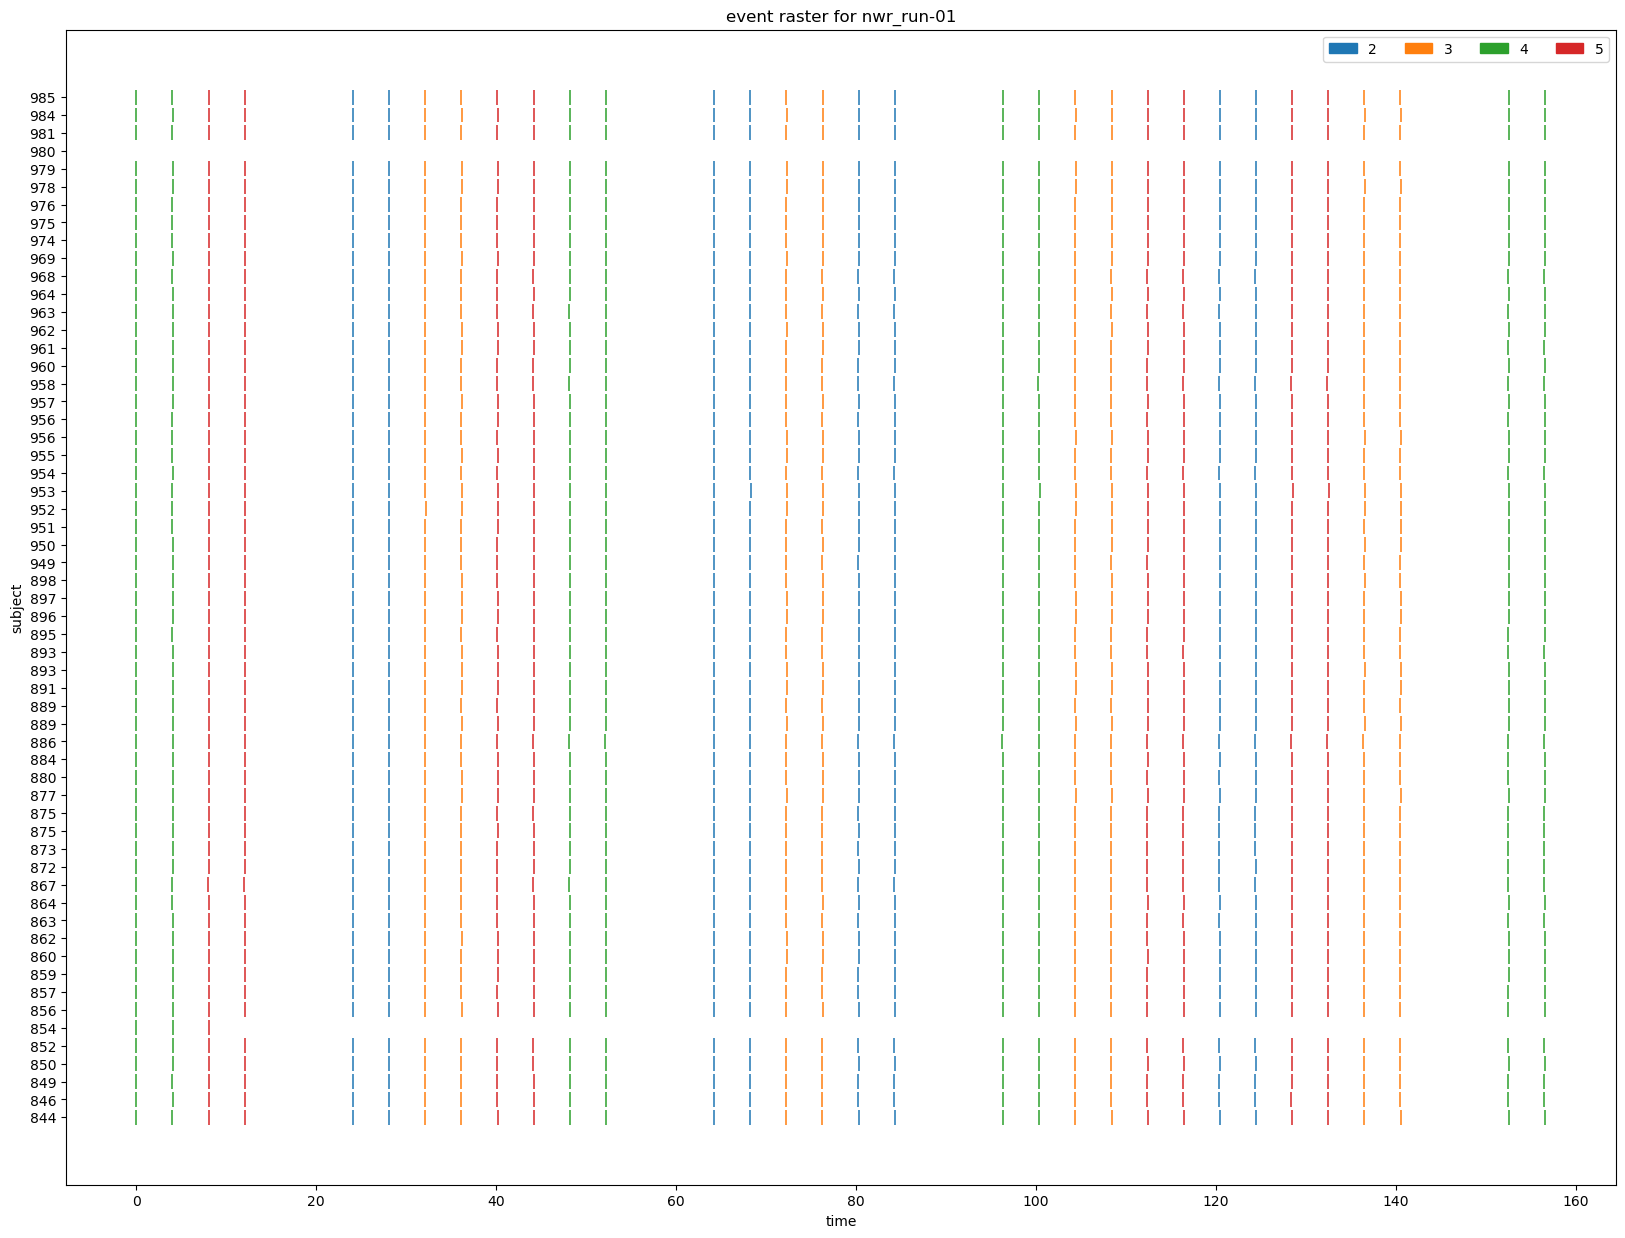

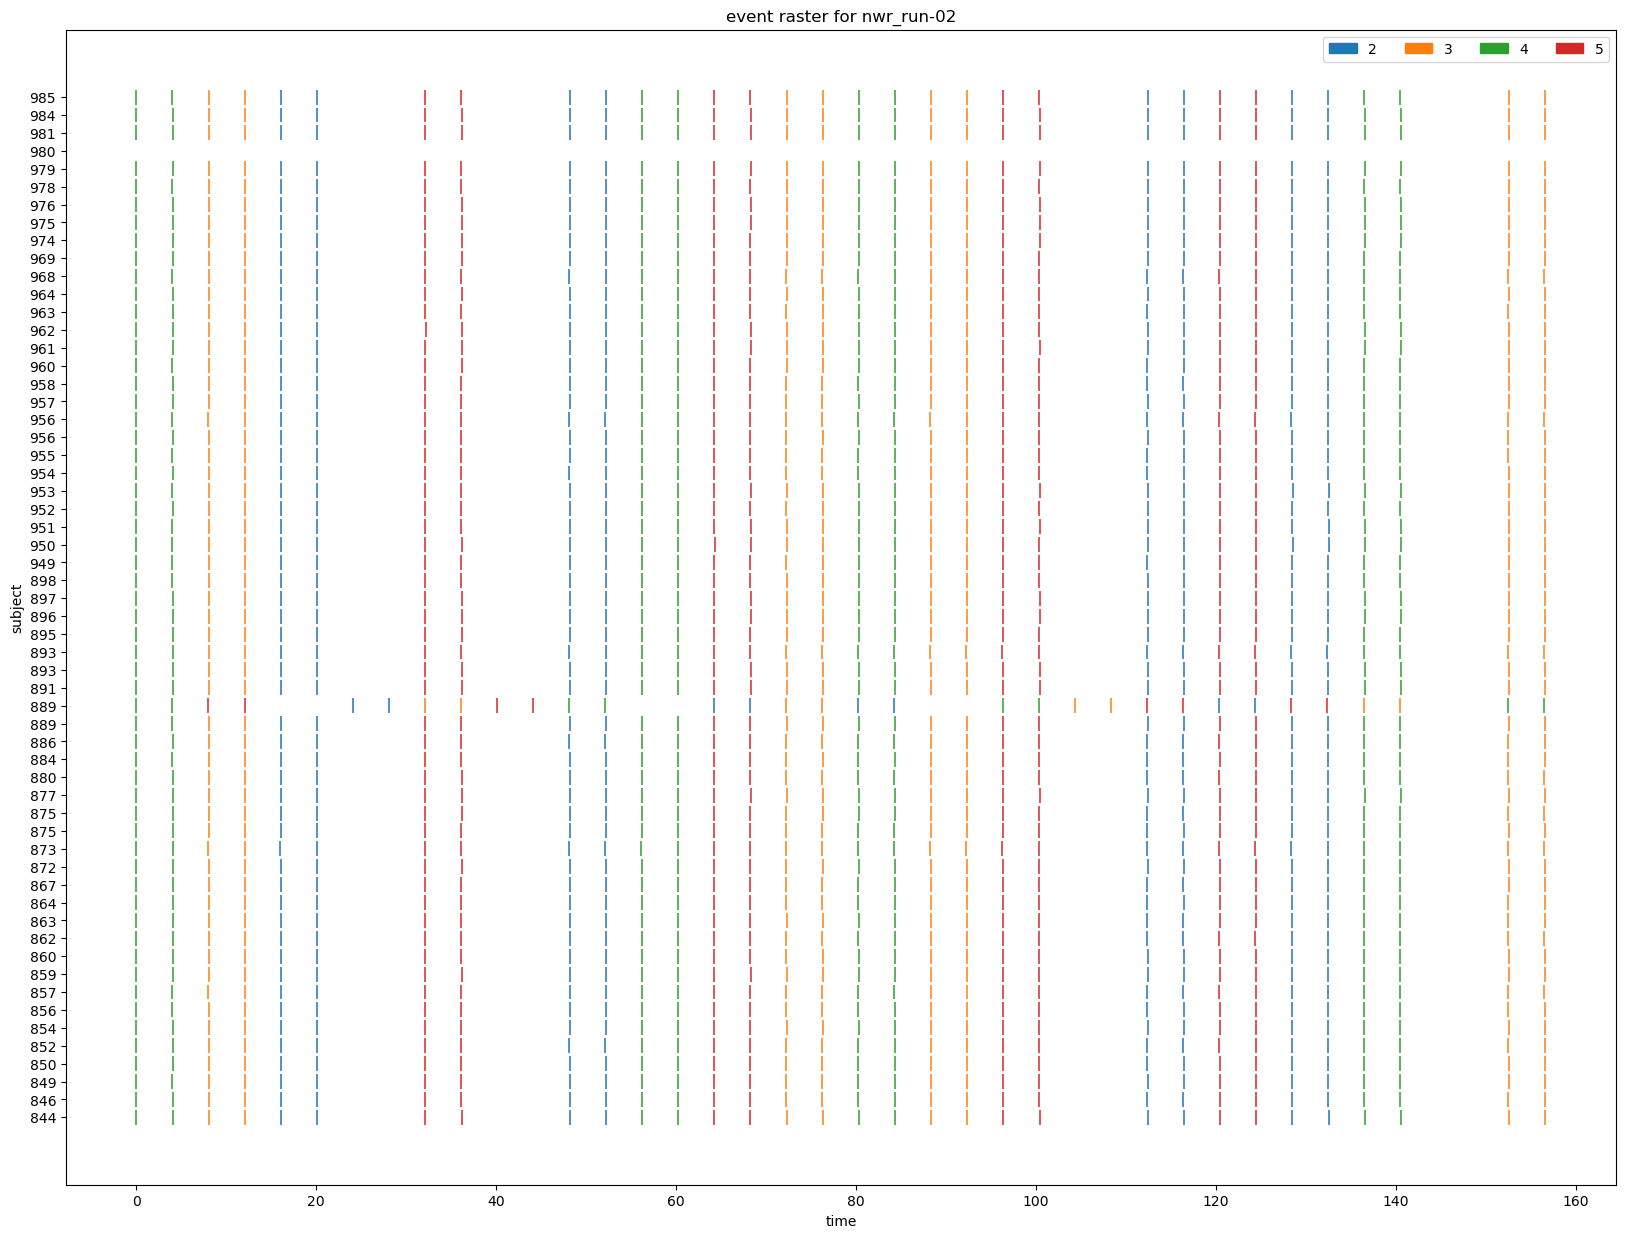

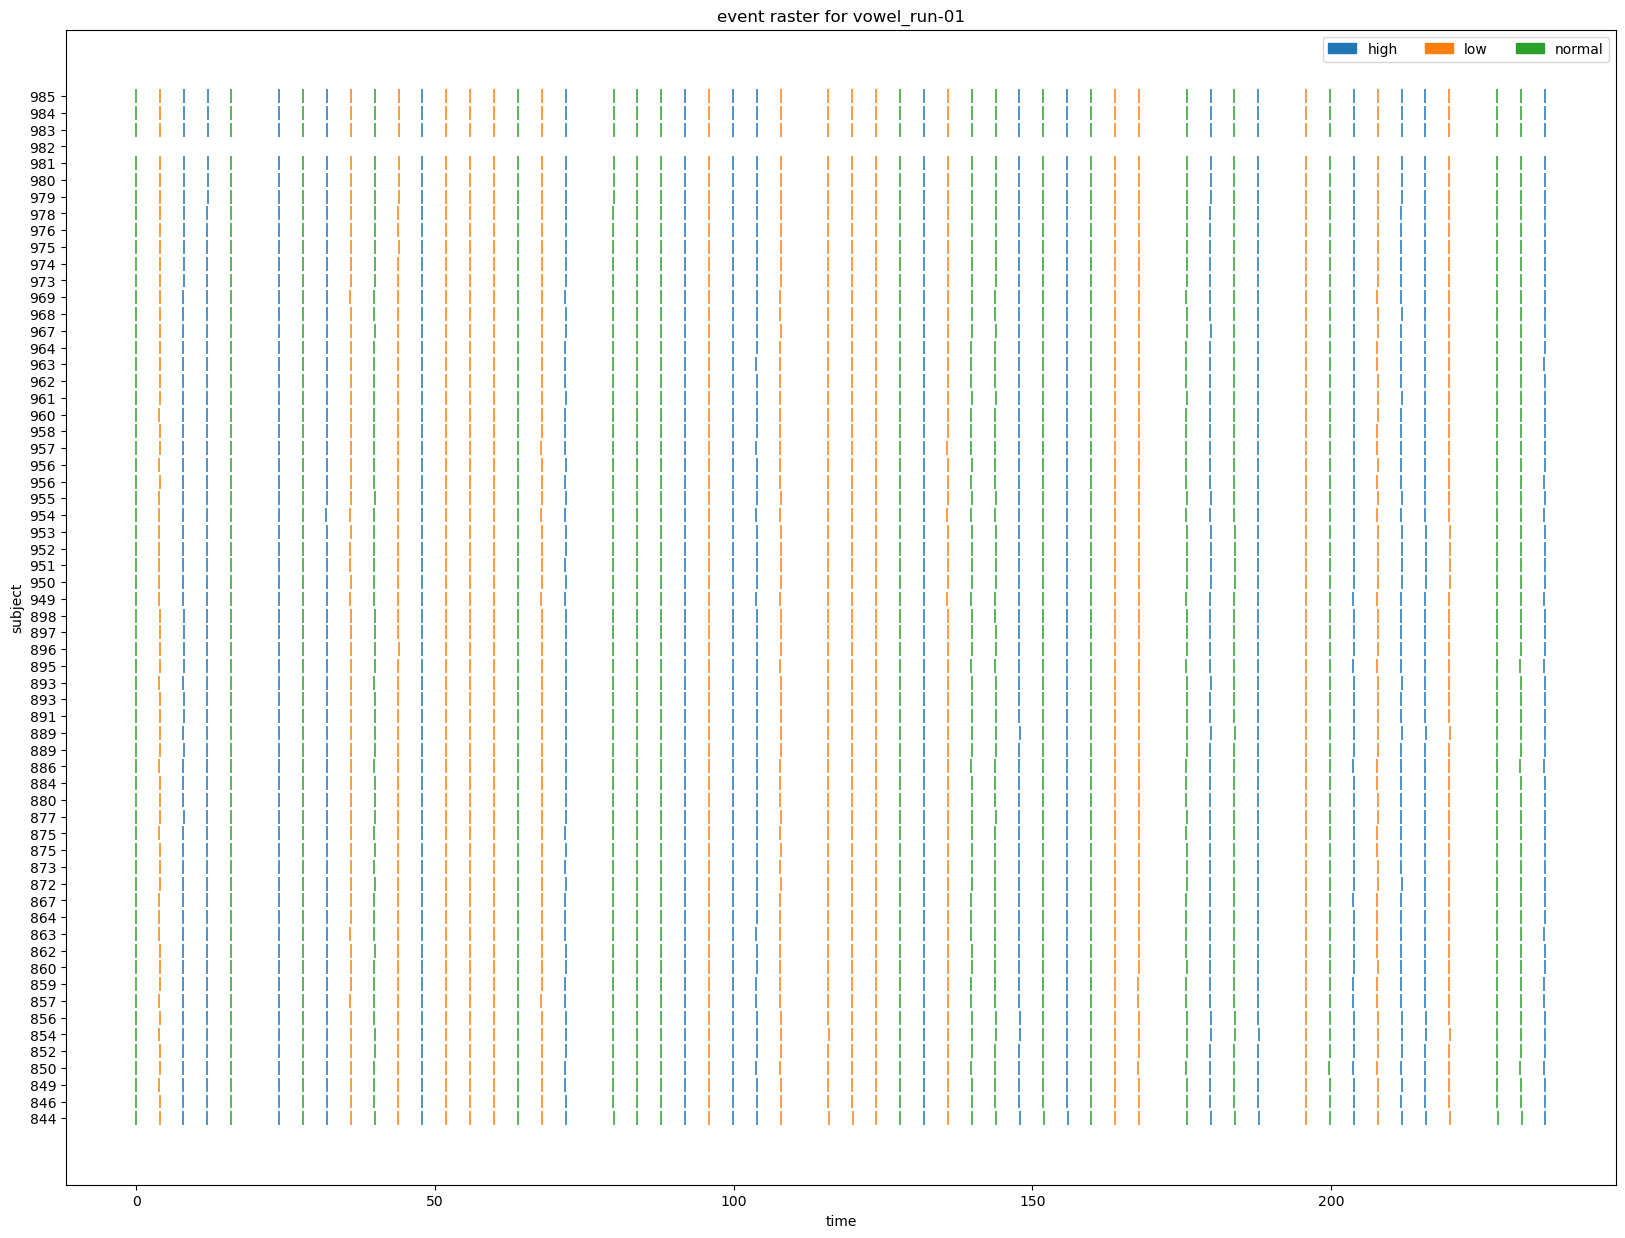

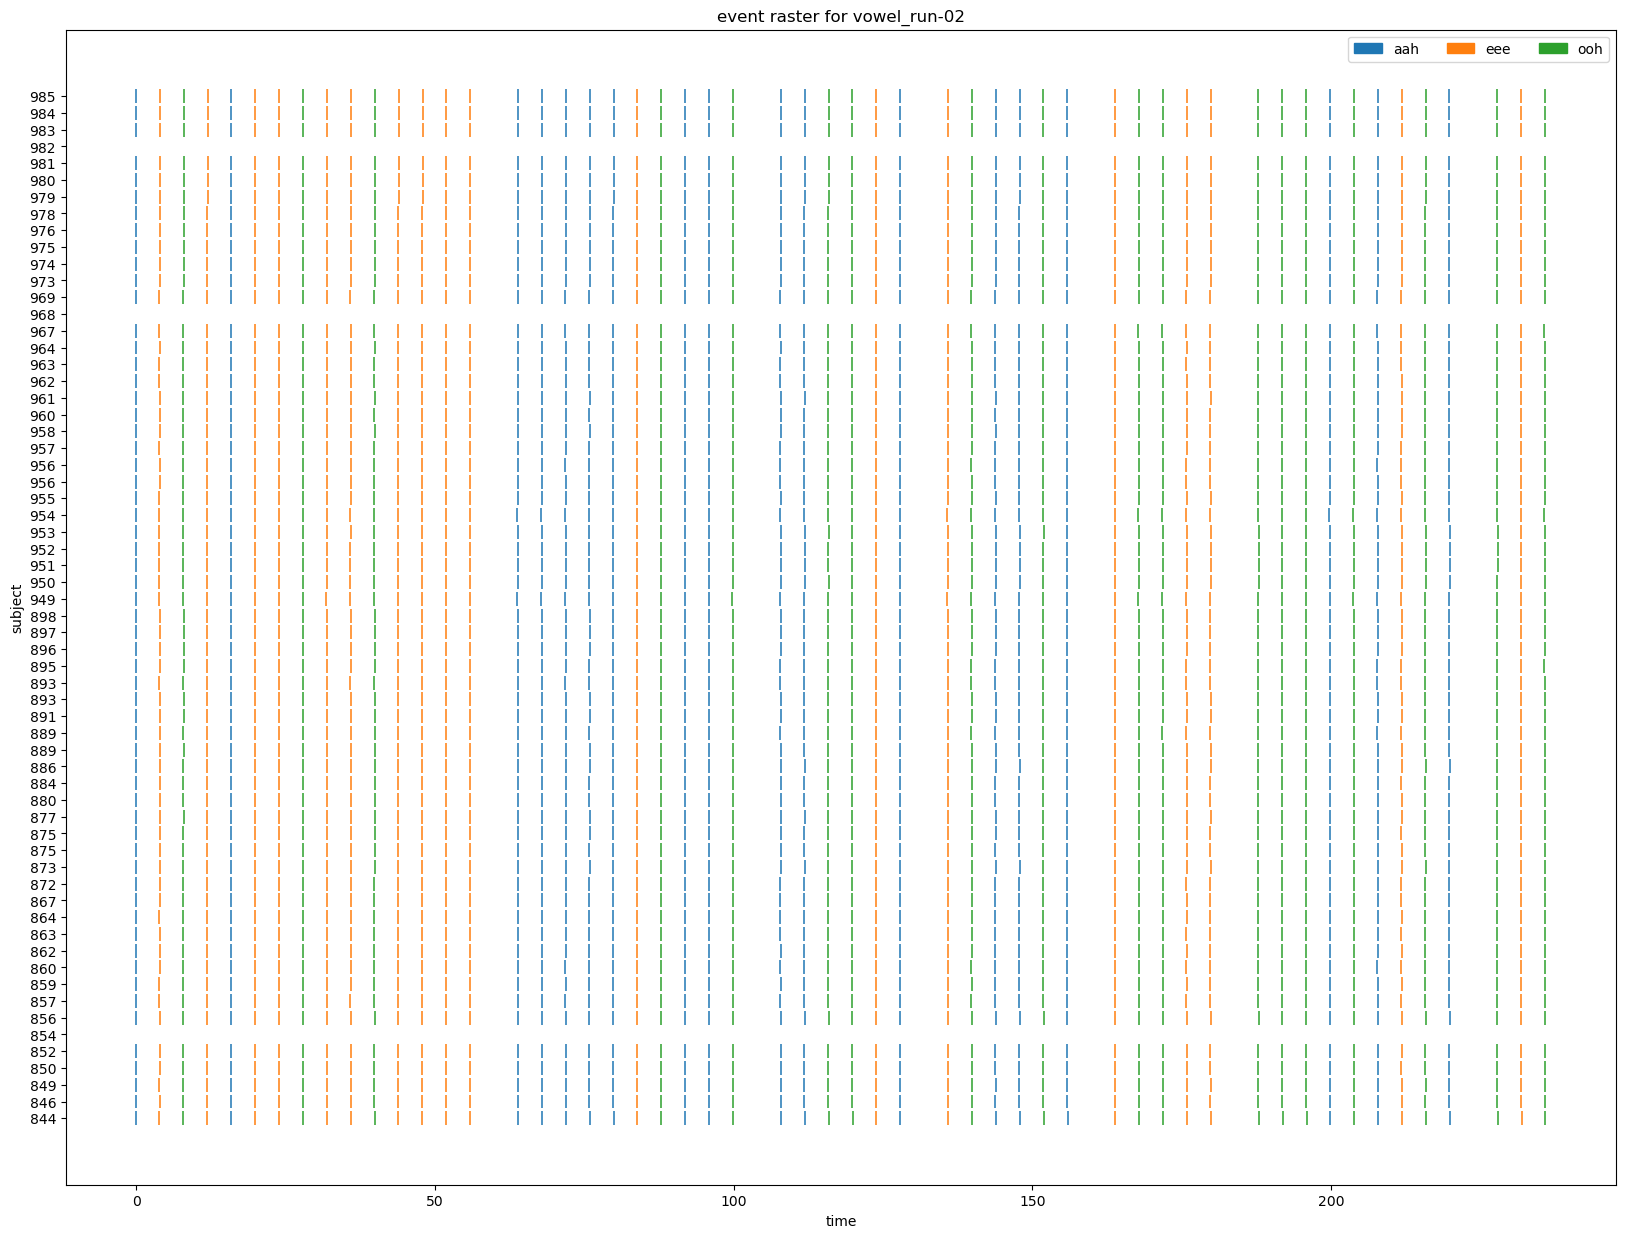

In [230]:
for k, files in events_by_taskrun.items():
    figure, ax = plt.subplots(figsize=(20,15))
    cmap = plt.cm.tab10
    lineoffsets = np.arange(0,len(files) + 1) * 1.2
    
    events = [pd.read_table(f) for f in files]


    for idx, ev in enumerate(events):
        if not ev.empty:
            event_labels = np.sort(events[1].trial_type.unique())
            cmap_dictionary = {label:idx for idx, label in enumerate(event_labels)}

            for grp, data in ev.groupby('trial_type'):
                if grp == 'silent':
                    continue
                elif grp == 'Rest':
                    continue
                else:
                    color = cmap.colors[cmap_dictionary[str(grp)]]
                    ax.eventplot(data.onset.to_numpy(), linewidths=data.duration.iloc[0], lineoffsets=lineoffsets[idx], colors=color)

    if 'nwr' in k:
        cmap_dictionary.pop('Rest')
    else:
        cmap_dictionary.pop('silent')

    handles = []
    for label, idx in cmap_dictionary.items():
        patch = mpatches.Patch(color=cmap.colors[idx], label=label)
        handles.append(patch)

    _ = ax.legend(handles=handles, ncol=4)

    plt.xlabel('time')
    plt.ylabel('subject')

    labels = [f.split('func/sub-voice')[1].split('_task')[0] for f in files]
    plt.yticks(ticks = lineoffsets[:-1], labels=labels)
    plt.title(f'event raster for {k}')
    plt.show()

In [ ]:
def binary_mapper(task_run, val):
    if 'pataka' in task_run or 'emosent' in task_run or 'vowel' in task_run:
        if val == 'silent':
            return 0
        else:
            return 1
    elif 'nwr' in task_run:
        if val == 'Rest':
            return 0
        else:
            return 1  

def event_mapper(task_run, events):
    if 'pataka' in task_run: 
        event_dict = {
            'clear': 1,
            'normal': 2,
            'rapid': 3,
            'silent': 0
        }
        
        #
#         if val == 'silent':
#             return 0
#         else:
#             return 1
    elif 'emosent' in task_run:
        event_dict = {
            'happy': 1,
            'neutral': 2,
            'sad': 3,
            'silent': 0
        }

    elif 'vowel' in task_run:
        event_dict = {
            'aah': 1,
            'eee': 2,
            'ooh': 3,
            'silent': 0
        }
        
    elif 'nwr' in task_run:
        event_dict = {
            '2': 2,
            '3': 3,
            '4': 4,
            '5': 5,
            'Rest' : 0
        }
    events = events.replace({'trial_type':event_dict})
    return events

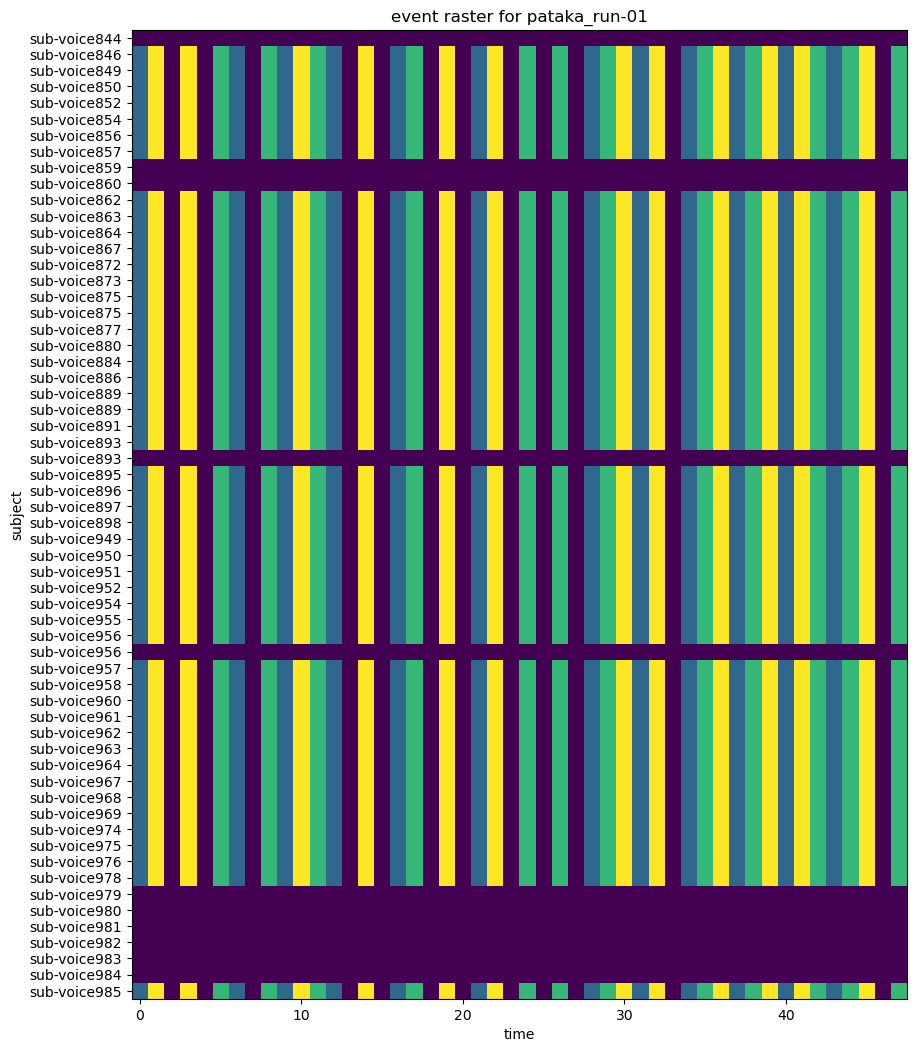

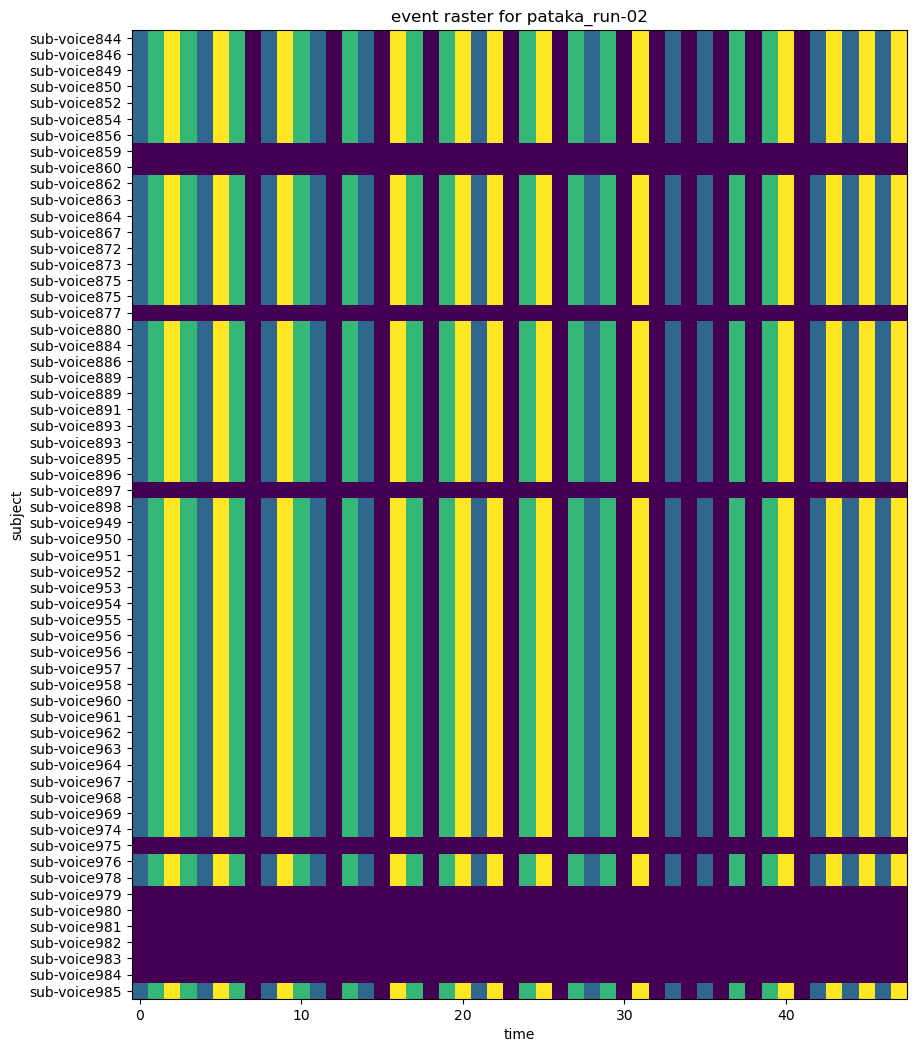

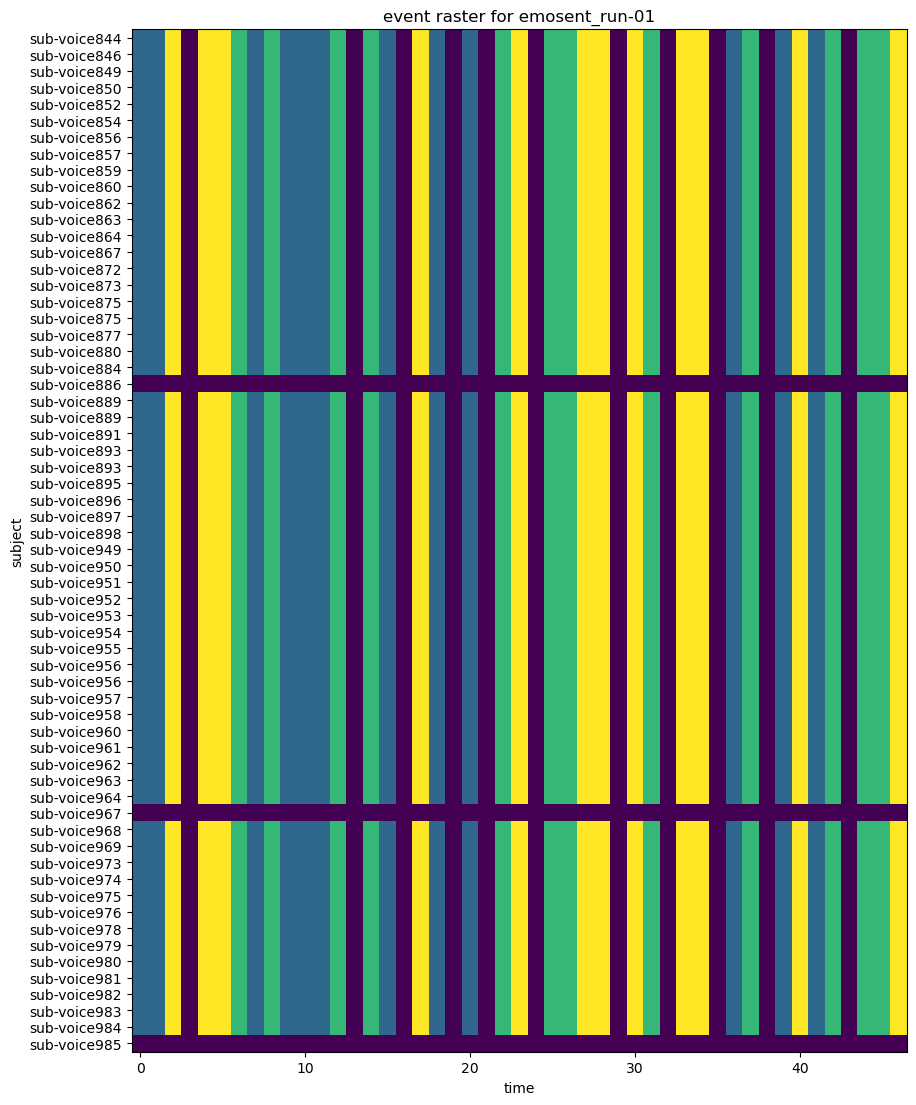

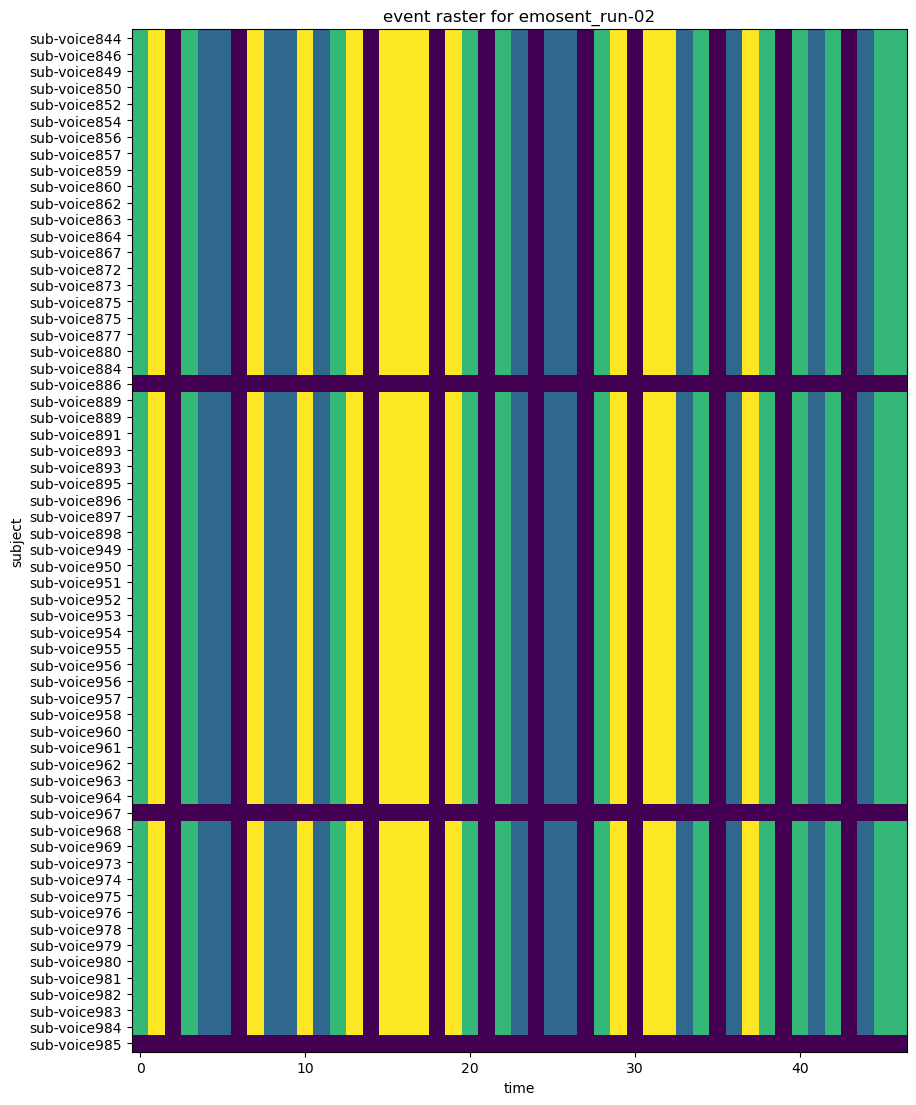

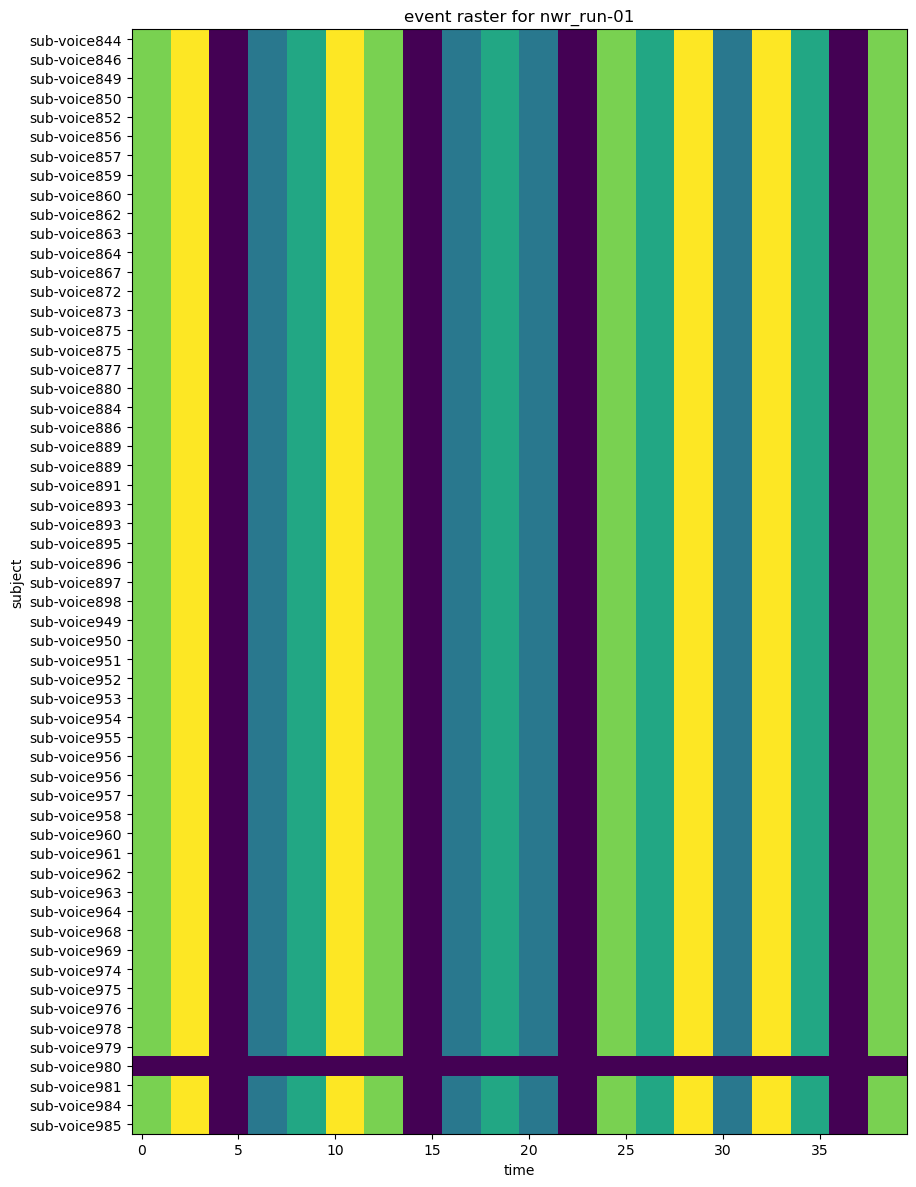

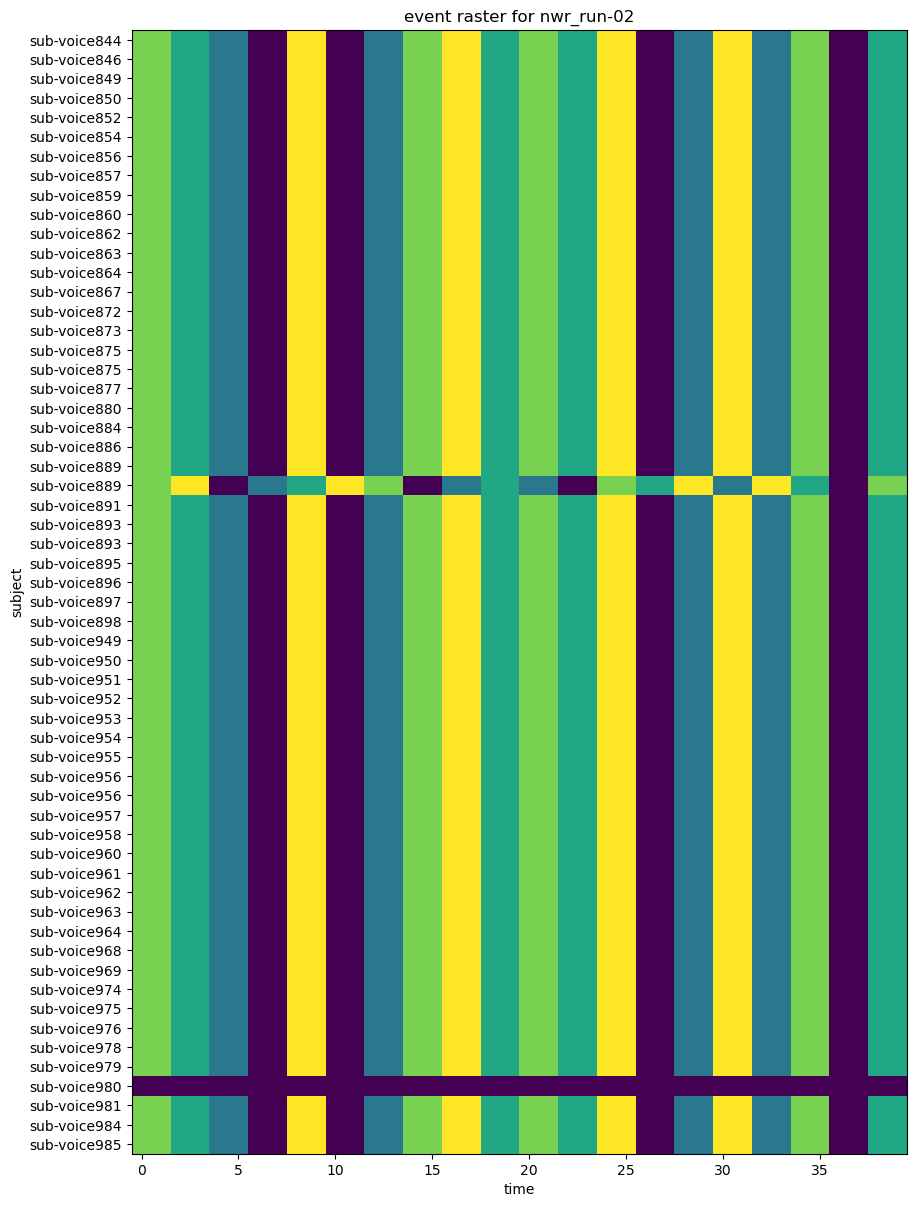

TypeError: Image data of dtype object cannot be converted to float

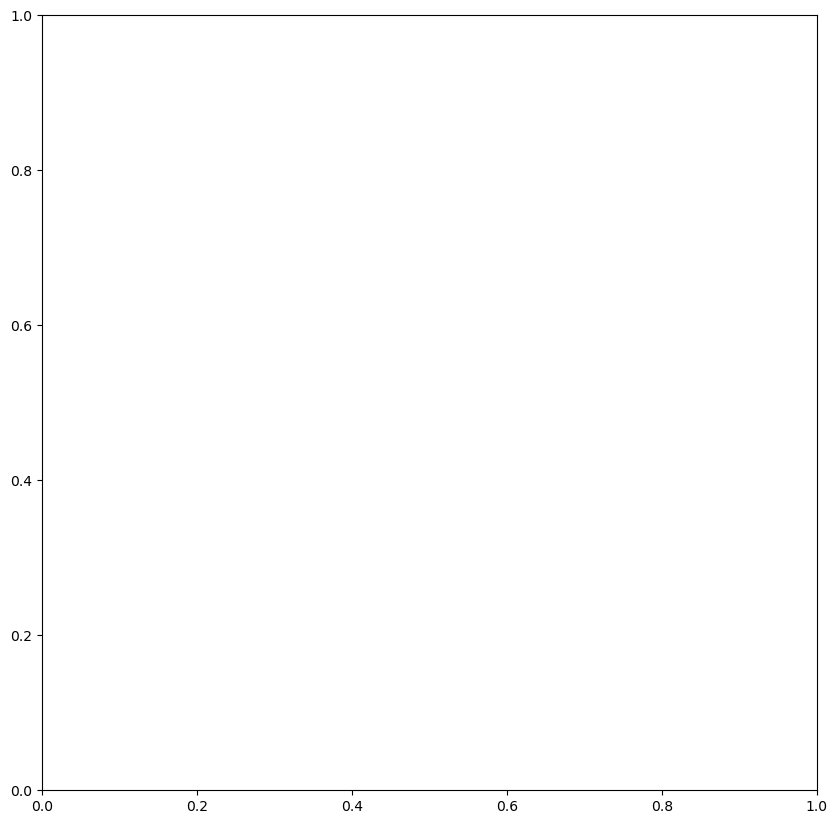

In [11]:
for k, test in events_by_task.items():
    
    #creat time stamps (assuming all about the same for each task-run after testing for pataka)
    test_populated = [pd.read_table(f).onset for f in test if not pd.read_table(f).empty]
    time = test_populated[0].to_numpy()
    
    raster = {}

    for f in test:
        ev = pd.read_table(f)
        name = f.split('func/')[1].split('_events.tsv')[0]
        if not ev.empty:
            if ev.shape[0] == time.shape[0]:
                raster[name] = event_mapper(k,ev).trial_type#ev.trial_type.apply(lambda x: binary_mapper(k, x)).to_numpy()
        else:
            raster[name] = np.zeros(time.shape).astype('int64') 
    raster_df = pd.DataFrame.from_dict(raster)
    raster_df.index = time
    raster_df=raster_df.transpose()

    plt.figure(figsize=(10, 20))
    plt.imshow(raster_df)
    plt.xlabel('time')
    plt.ylabel('subject')
    
    labels = [i.split('_ses')[0] for i in raster_df.index]
    plt.yticks(ticks = range(0,raster_df.shape[0]), labels=labels)
    plt.title(f'event raster for {k}')
    plt.show()

In [95]:
#pop_events['subject'] = [int(parse_file_entities(f)['subject'].split('voice')[1]) for f in pop_events.events_file]
pop_events['subject'] = [parse_file_entities(f)['subject'] + 'ses-' + parse_file_entities(f)['session'] 
                         for f in pop_events.events_file]

<Axes: title={'center': 'Number of populated (True) and unpopulated events per task'}, xlabel='task,populated'>

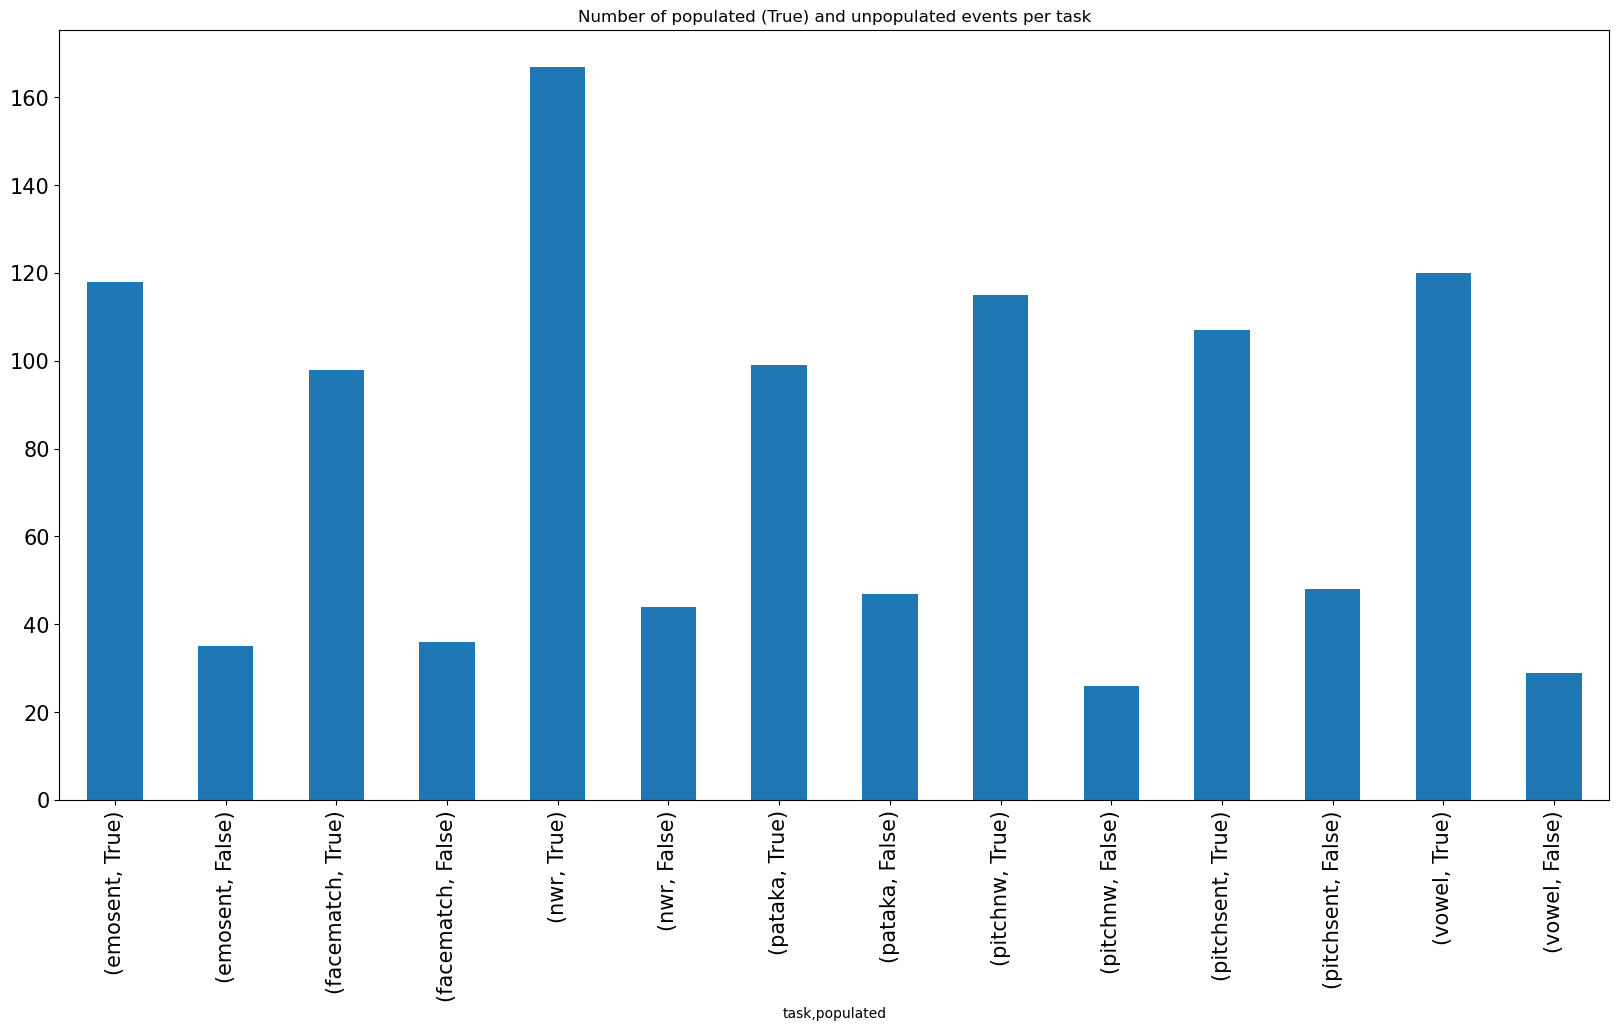

In [96]:
counts_by_task = pop_events.groupby('task').populated.value_counts()
counts_by_task.plot(kind='bar', figsize = (20,10), 
                    title ='Number of populated (True) and unpopulated events per task', fontsize=15)

<Axes: title={'center': 'Number of populated events per subject/session'}, xlabel='subject'>

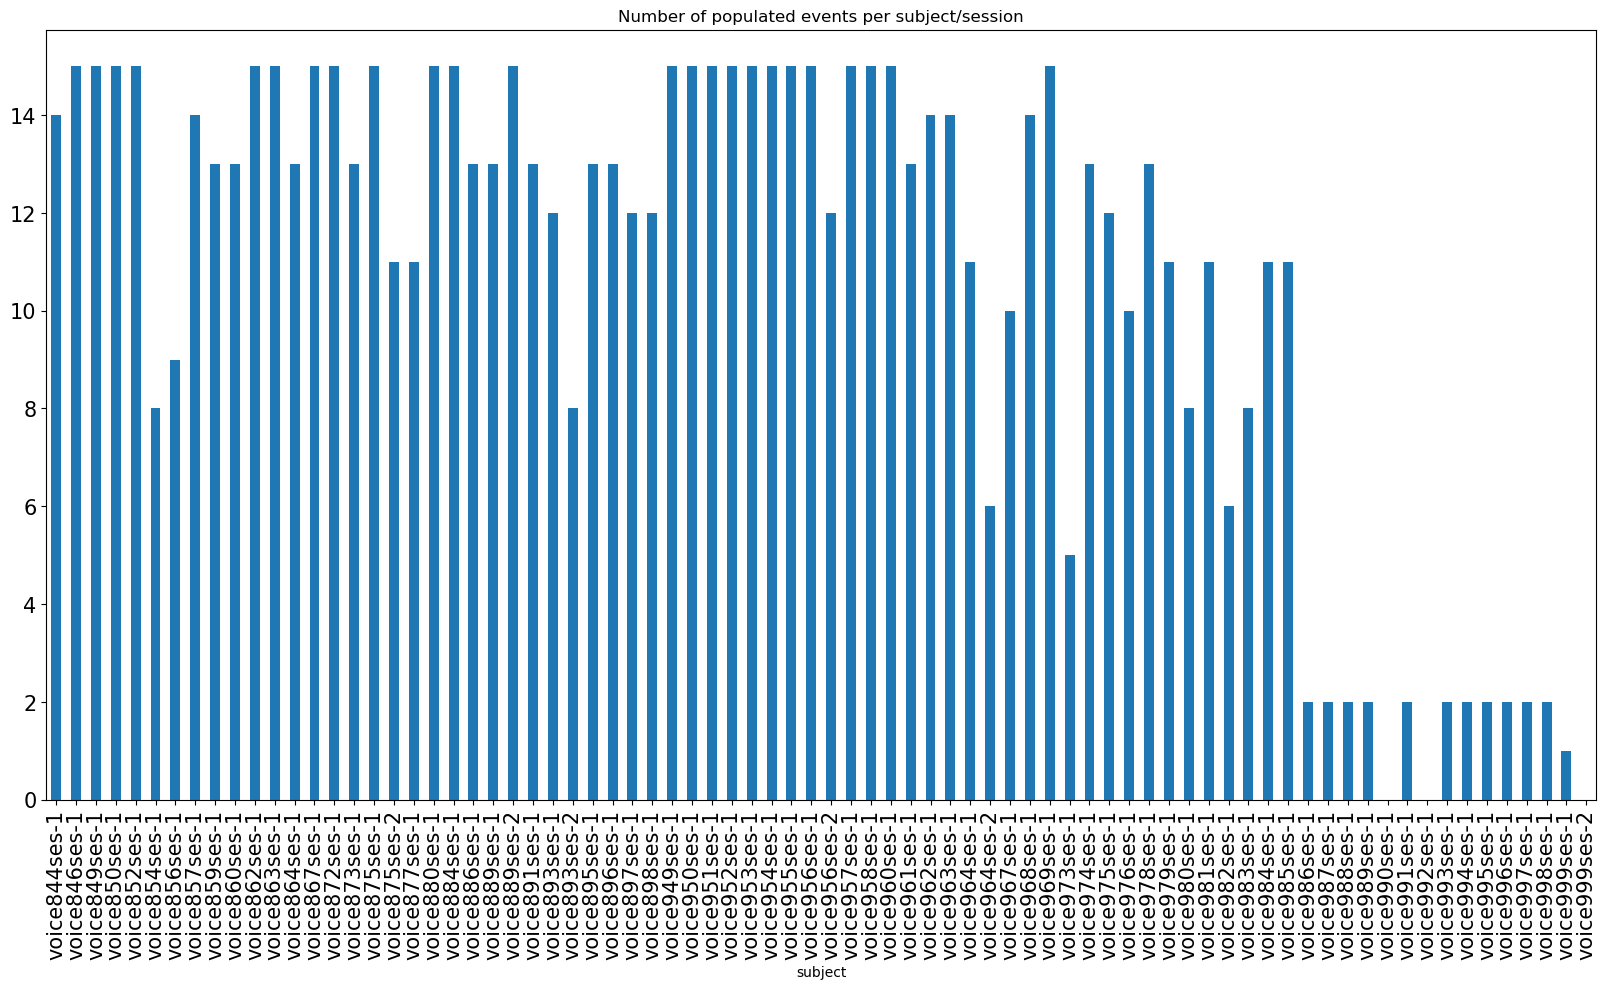

In [98]:
counts_by_subject = pop_events.groupby('subject').populated.sum()
counts_by_subject.plot(kind='bar', figsize = (20,10), title ='Number of populated events per subject/session', fontsize=15)

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>,
        <Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>,
        <Axes: title={'center': '4'}>, <Axes: title={'center': '5'}>,
        <Axes: title={'center': '6'}>],
       [<Axes: title={'center': '7'}>, <Axes: title={'center': '8'}>,
        <Axes: title={'center': '9'}>, <Axes: title={'center': '10'}>,
        <Axes: title={'center': '11'}>, <Axes: title={'center': '12'}>,
        <Axes: title={'center': '13'}>],
       [<Axes: title={'center': '14'}>, <Axes: title={'center': '15'}>,
        <Axes: title={'center': '16'}>, <Axes: title={'center': '17'}>,
        <Axes: title={'center': '18'}>, <Axes: title={'center': '19'}>,
        <Axes: title={'center': '20'}>],
       [<Axes: title={'center': '21'}>, <Axes: title={'center': '22'}>,
        <Axes: title={'center': '23'}>, <Axes: title={'center': '24'}>,
        <Axes: title={'center': '25'}>, <Axes: title={'center': '26'}>,
        <Axes: title={'

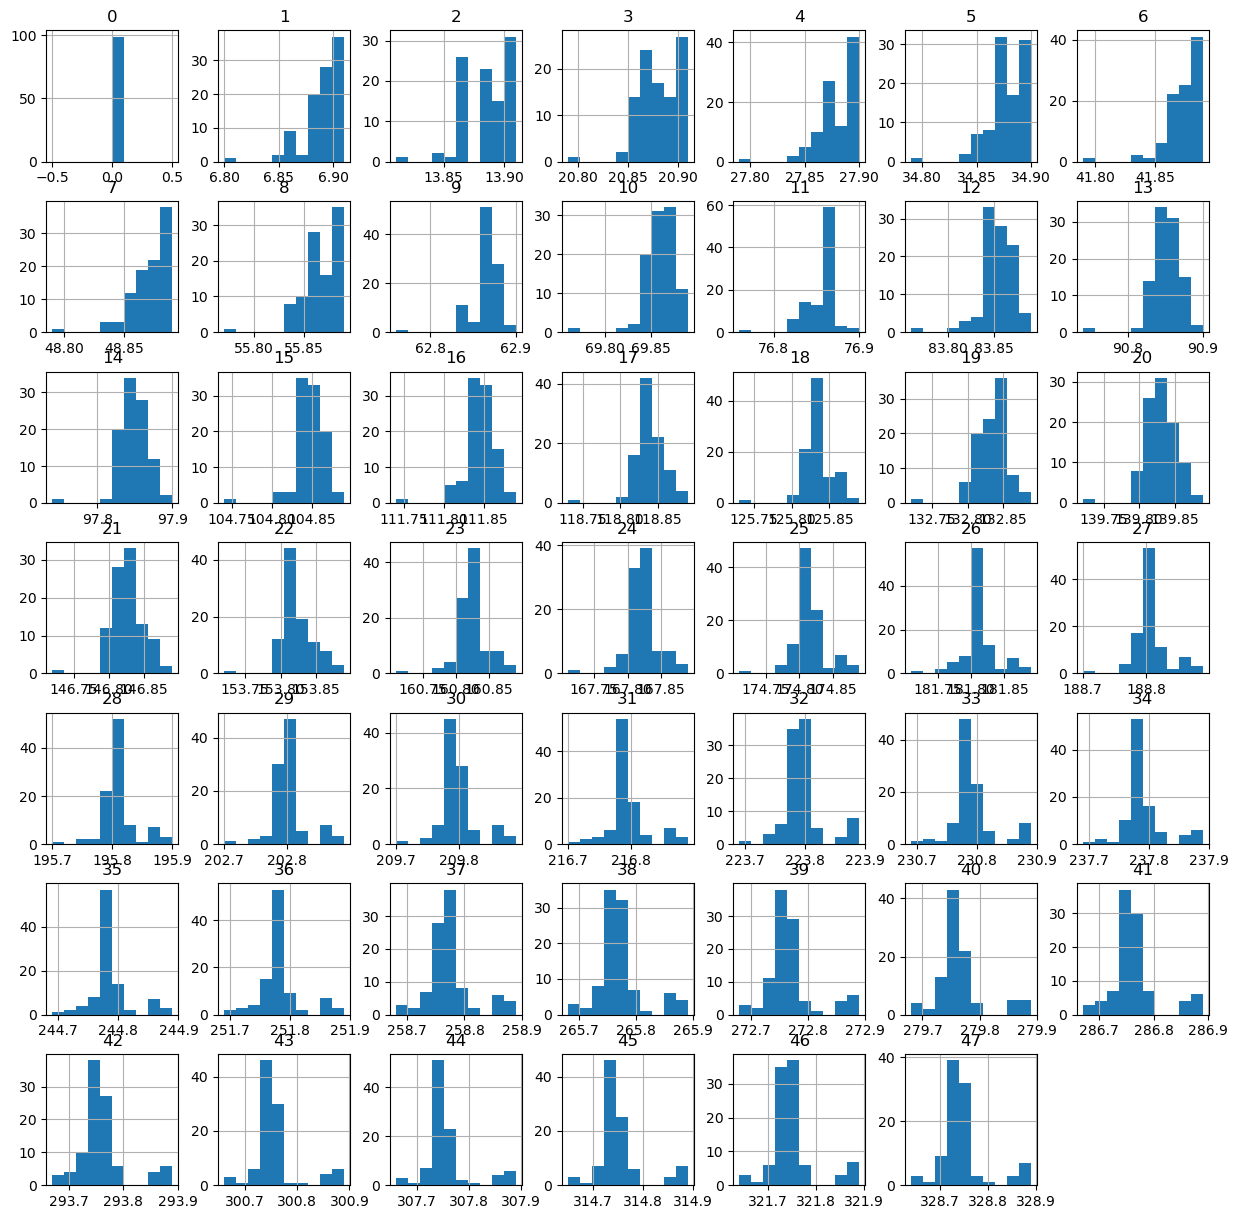

In [39]:
#test for one task that the timestamps are roughly the same
test = events_by_task['pataka']
good = [pd.read_table(f).onset for f in test if not pd.read_table(f).empty]
good_df = pd.DataFrame(good)
good_df.hist(figsize=(15,15))